## Importing Libraries
Importing required libraries

Only numpy for math and matplotlib for visualization required.

In [1]:
import numpy as np
# Importing libraries required for visualization
import matplotlib.pyplot as plt
# Using plot style from fivethirtyeight
plt.style.use('fivethirtyeight')

## Game Environment

The 5 different features are represented on the game map as follows:


*   The Open space is represented as 'O'
*   The Obstacle/Wall is represented as 'W'
* The Treasure is represented as 'T'
* The Enemy is represented as 'E'
* And Our (Agent's) position is denoted by 'X'




In [2]:
# Defining constants for the Game Map
OPEN_SPACE = 'O'
OBSTACLE = 'W'
TREASURE = 'T'
ENEMY = 'E'
ME = 'X'

The following GameMap class defines an object that we can use as the game environment for the Reinforcement learning algorithm. I have made this environment class close to how the OpenAI GYM environments work, as an environment the class needed the following properties:

*   Initializes a text based maze/grid in a form of 2d-array or list of list. Takes input the size x and y, takes the treasure location, obstacle Positions, enemy postion and place them accordingly.
*   The environment should be able to perform some actions and return a reward, that is what the step function does.
* The environment should be able to update itself based on the actions performed and relay the  information to the agent.
* The environment should be able to check for legal/allowed moves and thats what the penaltyMove function does. For Penalties, the agent recieves low rewards for any obstacle/enemy encountered with no change in the position, i.e. low reward and no change similarly if the agent tries to go off the maze/grid the reward stays -1 and the position remains the same.
* The class has a reset function which resets the whole game environment/board as this is needed at the start of every episode for reinforcement learning algorithm
* The class defines a policy pi that is a dictionary of mappings from possible actions to the action space.



In [3]:
class GameMap:
  def __init__(self, gridX = 5, gridY = 5, treasurePos = [], obstaclesPos = [], enemyPos = []):
    self.gridSize = (gridX,gridY)
    self.x = gridX
    self.y = gridY
    self.gameMap = [[OPEN_SPACE for _ in range(self.y)] for _ in range(self.x)]
    self.enemy = enemyPos

    self.pi = {'U': [-1, 0] , 'D': [1, 0] , 'L': [0,-1], 'R': [0,1]} # Policy in this game map (agent can only move up/down/left/right)
    self.possibleActions = ['U', 'D', 'L', 'R'] # respective to the policy
    self.states = [(i,j) for i in range(gridX) for j in range(gridY)] # All the possible states

    # My position starting from 0,0 (top left corner of the grid)
    self.myPosition = (0,0)
    self.gameMap[0][0] = ME

    # Placing obstacle
    self.obstacles = obstaclesPos    
    for wall in self.obstacles:
      for o in wall:
        self.gameMap[o[0]][o[1]] = OBSTACLE

    # Place the treasure at the right bottom corner cell, if no treasure location is specified
    if len(treasurePos) == 0:
      self.treasure = [self.x-1,self.y-1]
    else:
      self.treasure = treasurePos

    # Placing treasure
    self.gameMap[self.treasure[0]][self.treasure[1]] = TREASURE

    # Placing the Enemy if given
    if len(enemyPos) != 0:
      self.gameMap[self.enemy[0]][self.enemy[1]] = ENEMY

  # Different rewards for enemy or obstacle
  def penaltyMove(self, state):
    x, y = state
    if x < 0 or x >= self.x: # Check for off grid move
      return True, -1
    if y < 0 or y >= self.y: # Check for off grid move
      return True, -1
    if self.gameMap[x][y] == ENEMY: # Checking for enemy
      return True, -10
    if self.gameMap[x][y] == OBSTACLE: # Checking for obstacle
      return True, -5
    return False, -1 # Everything fine
  
  # Updates the agent's current position on the map by moving the X and O
  def updatePosition(self, state):
    self.gameMap[self.myPosition[0]][self.myPosition[1]] = OPEN_SPACE # Replacing current position with an open space
    x, y = state # Unpacking the new position values
    self.myPosition = (x,y) # saving the new updated position
    self.gameMap[x][y] = ME # Updating the map to show the agent at new position
  
  # Takes a step with the provided action, the new state is then checked and the reward is returned respectively
  def step(self, action):
    newState = np.array(self.myPosition) + np.array(action) # Adds the action to current position, that is changes the current position by [1,0],[-1,0],[0,1], or [0,-1]
    if (newState[0] == self.treasure[0]) and (newState[1] == self.treasure[1]): # If the new state is the terminal state, we are done and the reward is 0
      done = True
      reward = 0
    else: # Otherwise we keep going with a -1 reward at every time step
      done = False
      reward = -1
    
    penalty, penaltyReward = self.penaltyMove(newState) # Check if the move made was valid or not
    if penalty: # If not valid, change the reward based on the ilegal move made and reset the position
      reward = penaltyReward # Reward for moving towards an enemy or obstacle
      newState = self.myPosition # No move since there is an enemy or obstacle so back to original position

    self.updatePosition(newState)

    return newState, reward, done

  # Defining the reset function since we need to reset after every episode
  def reset(self):
    # Resetting the game map
    self.gameMap = [[OPEN_SPACE for _ in range(self.y)] for _ in range(self.x)]
    # resetting My position starting from 0,0 (top left corner of the grid)
    self.myPosition = (0,0)
    self.gameMap[self.myPosition[0]][self.myPosition[1]] = ME
    # Replacing obstacle  
    for wall in self.obstacles:
      for o in wall:
        self.gameMap[o[0]][o[1]] = OBSTACLE
    # Replacing treasure
    self.gameMap[self.treasure[0]][self.treasure[1]] = TREASURE
    # Replacing the Enemy
    if len(self.enemy) != 0:
      self.gameMap[self.enemy[0]][self.enemy[1]] = ENEMY

    return self.myPosition

  def __repr__(self):
    stringMap = "Game Map:\n"
    for r in range(self.x):
      stringMap += f"{self.gameMap[r]}\n"
    return f"Grid Size: {self.gridSize}; Treasure: {self.treasure} \n" + stringMap

## Reinforcement Learning

The following RLAgent class defines an agent which can perform actions in the provided environment. The agent initializes a Q table for state action pairs, for our environment we have 4 actions for every state possible that is up/down/left/right. 

The RLAgent class defines 3 different training algorithm:

*   The first one is a Q learning approach where the Q table is updated using epsilon greedy strategy for exploration vs exploitaion. The epsilon is started at 1 that is purely in an exploratory mode, and the epsilon decay happens after every episode reducing 10% from the previous episode. This epsilon decay method allows the algorithm to explore and learn about the states in the environment when the agent starts off with no information. Once the epsilon reaches 0 the agent only makes decisions by exploiting the Q-table and hence takes smart decisions rather than random exploring decisions
*   The second one is a Value iteration algorithm based on the bellman equation to maximize the transition from one state to another based on all the possible actions in the current state, for this the maximum reward possible in every state is chosen with this the state transition value table (V) gives us the number of steps required to reach the treasure location from any given state in the grid. In this method we explore all the possible states in the environment, hence we have information about all the states.
* The third one is similar to the previous value iteration method, the only difference in this is that we go over all the possible actions and take the average of all possible rewards rather than the maximum available. Similar to value iteration, this method  also explores the whole state space of the environment, and hence we have information about all the states.


The RL agent is negatively reinforced, that is the rewards are negative for every time step (-1), more negative for any unfavourable encounter with monster (-10) or obstacle (-5), and 0 when we find the treasure. This means the algorithm will try to reach/find the minimum number of steps required to complete the maze.

Since all the rewards are negative and only 0 when we are at the goal, that means the Q table initialized with all 0 is an optimistic choice as 0 is the maximum atainable reward in this environment.


In [4]:
class RLAgent:
  def __init__(self, grid):
    self.env = grid
    self.Q = {}
    for s in self.env.states:
      for a in self.env.possibleActions:
        self.Q[s,a] = 0 # Table for mapping every state with all posible action rewards pair

    self.gamma = 1 # Discount rate, far sighted with value of 1
    self.alpha = 0.1 # Learning rate
    self.epsilon = 1 # Using epsilon greedy strategy for exploration vs exploitation

    self.endState = self.env.treasure
  
  # Find the action with best reward to perform from the current state
  def maxAction(self, Q, state, actions):
    Q_values = np.array([Q[state, a] for a in actions]) # All Q transition values for all actions in the current state
    action = np.argmax(Q_values) # The index of the highest action/value pair from the current state
    return actions[action] # Returning the max action

  def train(self, numEpisodes = 1000):
    rewards = np.zeros(numEpisodes) # List of rewards for all episodes.

    for ep in range(numEpisodes):
      state = self.env.reset() # Resetting the environment at the start of every episode, so that the agent is at the starting position
      if ep % 100 == 0:
        print(f"Starting Episode: {ep}")
      done = False # Reset the done flag
      episodeReward = 0 # Total reward for this episode
      
      if ep == numEpisodes - 1:
        print("\nThe agent follows the following path:")

      while not done:
        if ep == numEpisodes - 1: # For the last episode
          print(self.env)
        rand = np.random.random() # Random number for epsilon greedy strategy
        if rand < (1-self.epsilon): # Exploit if the random number is less than 1-epsilon
          action = self.maxAction(self.Q, state, self.env.possibleActions)
        else: # Explore a random action in this state
          action = np.random.choice(self.env.possibleActions)

        newState, reward, done = self.env.step(self.env.pi[action]) # Perforeming the selected action
        episodeReward += reward
        nS = (newState[0],newState[1])

        newAction = self.maxAction(self.Q, nS, self.env.possibleActions)

        self.Q[state, action] = self.Q[state, action] + self.alpha*(reward + self.gamma*self.Q[nS, newAction])

        state = nS

      # Decreasing epsilon linearly
      self.epsilon = 0.9*self.epsilon # Epsilon Decay
      rewards[ep] = episodeReward
    print(self.env)
    print(f"Total Reward for the last episode: {episodeReward}")
    plt.figure(figsize=(10,5))
    plt.plot(range(numEpisodes),rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Reward Convergence")
    # return rewards

  def actionReward(self, initialState, action):
    reward = -1
    # If treasure found reward is 0
    if initialState[0] == self.endState[0] and initialState[1] == self.endState[1]:
        return initialState, 0

    newState = np.array(initialState) + np.array(action)  

    if -1 in newState or self.env.x == newState[0] or self.env.y == newState[1]:
      newState = initialState

    # Return reward based on the state, -1 for eQery time step, -10 for monsters, -5 for obstacle and 0 for treasure
    if self.env.gameMap[newState[0]][newState[1]] == OBSTACLE:
      newState = initialState
      reward = -5
    if self.env.gameMap[newState[0]][newState[1]] == ENEMY:
      newState = initialState
      reward = -10
        
    return newState, reward  

  def valueIteration(self, numEpisodes = 100):
    self.V = np.zeros(self.env.gridSize)
    states = [[i,j] for i in range(self.env.x) for j in range(self.env.y)] # All the possible states
    actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
    print("Episode 0")
    print(f"Sate Value: \n{self.V}")
    print("")

    for epoch in range(numEpisodes):
      cV = np.copy(self.V)
      for s in states: # For all states
        newR = [0,0,0,0]
        i = 0
        for a in actions: # For all possible actions from that state
          newState, reward = self.actionReward(s, a)
          newR[i] += reward+(self.gamma*self.V[newState[0], newState[1]])
          i += 1
        cV[s[0], s[1]] = max(newR)
      if epoch > 1 and (self.V == cV).all():
        print(f"CONVERGED at Episode: {epoch + 1} \nState Value: \n{self.V} \n")
        break
      self.V = cV
      if (epoch + 1) % 2 == 0:
        print(f"Episode: {epoch+1} \nState Value: \n{self.V} \n")

  # Similar to value iteration but takes the average of all action/rewards per state rather than the max
  def policyIteration(self, numEpisodes = 100):
    self.V = np.zeros(self.env.gridSize)
    states = [[i,j] for i in range(self.env.x) for j in range(self.env.y)] # All the possible states
    actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
    print("Episode 0")
    print(self.V)
    print("")

    for epoch in range(numEpisodes):
      cV = np.copy(self.V)
      for s in states: # For all states
        newR = 0
        for a in actions: # For all possible actions from that state
          newState, reward = self.actionReward(s, a)
          newR += (1/4)*(reward+(self.gamma*self.V[newState[0], newState[1]]))
        cV[s[0], s[1]] = newR
      if epoch > 1 and (self.V - cV < 0.01).all():
        print(f"CONVERGED at Episode: {epoch + 1} \nState Value: \n{self.V} \n")
        break
      self.V = cV
      if (epoch + 1) % 2 == 0:
        print(f"Episode: {epoch+1} \nState Value: \n{self.V} \n")
  
  def __repr__(self):
    stateMap = "States:\n"
    i = 0
    for r in self.env.states:
      stateMap += f"{r}\t"
      if (i+1) % self.env.gridSize[1] == 0:
        stateMap += "\n"
      i += 1

    stringMap = "Q-table: \n"
    for s in self.env.states:
      for a in self.env.possibleActions:
        stringMap += f"{self.Q[s,a]} "
      stringMap += f"\n"

    return f"Policy: {self.env.pi} Treasure: {self.endState}\n" + stringMap + stateMap


In [5]:
np.random.seed(123)
myMap = GameMap(obstaclesPos= [[[0,3],[1,3],[2,3]], [[2,0],[2,1]]], enemyPos=[3,3])
print(myMap)
myAgent = RLAgent(myMap)
myAgent

Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['X', 'O', 'O', 'W', 'O']
['O', 'O', 'O', 'W', 'O']
['W', 'W', 'O', 'W', 'O']
['O', 'O', 'O', 'E', 'O']
['O', 'O', 'O', 'O', 'T']



Policy: {'U': [-1, 0], 'D': [1, 0], 'L': [0, -1], 'R': [0, 1]} Treasure: [4, 4]
Q-table: 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
States:
(0, 0)	(0, 1)	(0, 2)	(0, 3)	(0, 4)	
(1, 0)	(1, 1)	(1, 2)	(1, 3)	(1, 4)	
(2, 0)	(2, 1)	(2, 2)	(2, 3)	(2, 4)	
(3, 0)	(3, 1)	(3, 2)	(3, 3)	(3, 4)	
(4, 0)	(4, 1)	(4, 2)	(4, 3)	(4, 4)	

Starting Episode: 0
Starting Episode: 100
Starting Episode: 200
Starting Episode: 300
Starting Episode: 400
Starting Episode: 500
Starting Episode: 600
Starting Episode: 700
Starting Episode: 800
Starting Episode: 900

The agent follows the following path:
Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['X', 'O', 'O', 'W', 'O']
['O', 'O', 'O', 'W', 'O']
['W', 'W', 'O', 'W', 'O']
['O', 'O', 'O', 'E', 'O']
['O', 'O', 'O', 'O', 'T']

Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['O', 'X', 'O', 'W', 'O']
['O', 'O', 'O', 'W', 'O']
['W', 'W', 'O', 'W', 'O']
['O', 'O', 'O', 'E', 'O']
['O', 'O', 'O', 'O', 'T']

Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['O', 'O', 'X', 'W', 'O']
['O', 'O', 'O', 'W', 'O']
['W', 'W', 'O', 'W', 'O']
['O', 'O', 'O', 'E', 'O']
['O', 'O', 'O', 'O', 'T']

Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['O', 'O', 'O', 'W', 'O']
['O', 'O', 'X', 'W', 'O']
['W', 'W', 'O', 'W', 'O']
['O', 'O', 'O', 'E', 'O']
['O', 'O', 'O', 'O', 'T']

Grid Size: (5, 5); Treasure: [4

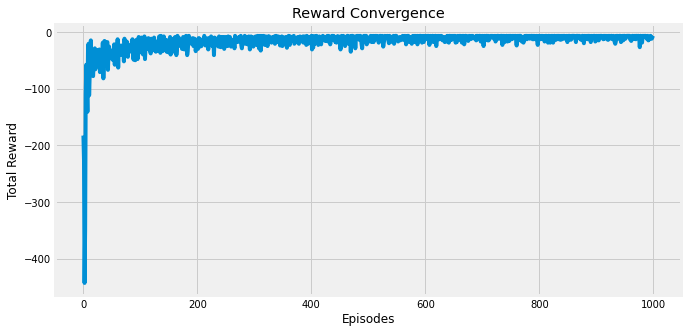

In [6]:
myAgent.train(numEpisodes=1000)

From the results above we can see how well Q-learning performs in this task, from the graph we can see how the algorithm went from doing really bad with a total reward of -350 in the first few episodes, but by the end the total reward is -7 that is the minimum number of steps required to complete the maze without encountering obstacles or monsters

From the path the agent takes we can see it avoids the obstacles very well.

The following example uses a different map to show the working of the agent

In [7]:
np.random.seed(321)
myMap2 = GameMap(obstaclesPos= [[[1,1],[1,2]], [[2,2],[3,2]]], treasurePos=(2,1), enemyPos=[1,0])
print(myMap2)
myAgent2 = RLAgent(myMap2)
myAgent2

Grid Size: (5, 5); Treasure: (2, 1) 
Game Map:
['X', 'O', 'O', 'O', 'O']
['E', 'W', 'W', 'O', 'O']
['O', 'T', 'W', 'O', 'O']
['O', 'O', 'W', 'O', 'O']
['O', 'O', 'O', 'O', 'O']



Policy: {'U': [-1, 0], 'D': [1, 0], 'L': [0, -1], 'R': [0, 1]} Treasure: (2, 1)
Q-table: 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
0 0 0 0 
States:
(0, 0)	(0, 1)	(0, 2)	(0, 3)	(0, 4)	
(1, 0)	(1, 1)	(1, 2)	(1, 3)	(1, 4)	
(2, 0)	(2, 1)	(2, 2)	(2, 3)	(2, 4)	
(3, 0)	(3, 1)	(3, 2)	(3, 3)	(3, 4)	
(4, 0)	(4, 1)	(4, 2)	(4, 3)	(4, 4)	

Starting Episode: 0
Starting Episode: 100
Starting Episode: 200
Starting Episode: 300
Starting Episode: 400
Starting Episode: 500
Starting Episode: 600
Starting Episode: 700
Starting Episode: 800
Starting Episode: 900

The agent follows the following path:
Grid Size: (5, 5); Treasure: (2, 1) 
Game Map:
['X', 'O', 'O', 'O', 'O']
['E', 'W', 'W', 'O', 'O']
['O', 'T', 'W', 'O', 'O']
['O', 'O', 'W', 'O', 'O']
['O', 'O', 'O', 'O', 'O']

Grid Size: (5, 5); Treasure: (2, 1) 
Game Map:
['O', 'X', 'O', 'O', 'O']
['E', 'W', 'W', 'O', 'O']
['O', 'T', 'W', 'O', 'O']
['O', 'O', 'W', 'O', 'O']
['O', 'O', 'O', 'O', 'O']

Grid Size: (5, 5); Treasure: (2, 1) 
Game Map:
['O', 'O', 'X', 'O', 'O']
['E', 'W', 'W', 'O', 'O']
['O', 'T', 'W', 'O', 'O']
['O', 'O', 'W', 'O', 'O']
['O', 'O', 'O', 'O', 'O']

Grid Size: (5, 5); Treasure: (2, 1) 
Game Map:
['O', 'O', 'O', 'X', 'O']
['E', 'W', 'W', 'O', 'O']
['O', 'T', 'W', 'O', 'O']
['O', 'O', 'W', 'O', 'O']
['O', 'O', 'O', 'O', 'O']

Grid Size: (5, 5); Treasure: (2

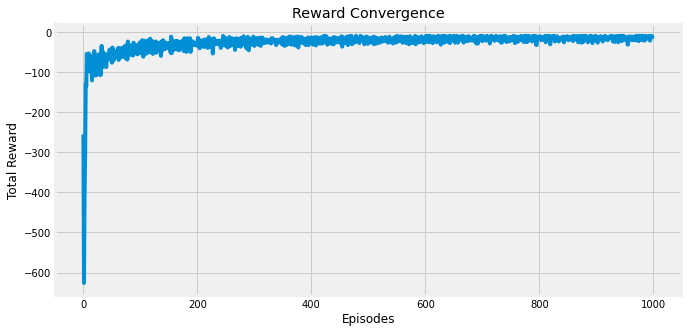

In [8]:
myAgent2.train(numEpisodes=1000)

From these results again we can see the RL agent converges on the best reward possible in the environment, from the path it takes we can see it knows to avoid the obstacles and the enemies, which makes it go around the fence to reach the goal requiring 10 minimum steps rather than 2 if the enemy werent there.

The following example uses the value iteration method, since this method explores all the possible states I chose a simpler map to show the exploration benefits.

In [9]:
myMap3 = GameMap()
print(myMap3)
myAgent3 = RLAgent(myMap3)
myAgent3.valueIteration(numEpisodes = 1000)

Grid Size: (5, 5); Treasure: [4, 4] 
Game Map:
['X', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'T']

Episode 0
Sate Value: 
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Episode: 2 
State Value: 
[[-2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -1.]
 [-2. -2. -2. -1.  0.]] 

Episode: 4 
State Value: 
[[-4. -4. -4. -4. -4.]
 [-4. -4. -4. -4. -3.]
 [-4. -4. -4. -3. -2.]
 [-4. -4. -3. -2. -1.]
 [-4. -3. -2. -1.  0.]] 

Episode: 6 
State Value: 
[[-6. -6. -6. -5. -4.]
 [-6. -6. -5. -4. -3.]
 [-6. -5. -4. -3. -2.]
 [-5. -4. -3. -2. -1.]
 [-4. -3. -2. -1.  0.]] 

Episode: 8 
State Value: 
[[-8. -7. -6. -5. -4.]
 [-7. -6. -5. -4. -3.]
 [-6. -5. -4. -3. -2.]
 [-5. -4. -3. -2. -1.]
 [-4. -3. -2. -1.  0.]] 

CONVERGED at Episode: 9 
State Value: 
[[-8. -7. -6. -5. -4.]
 [-7. -6. -5. -4. -3.]
 [-6. -5. -4. -3. -2.]
 [-5. -4. -3. -2. -1.]


In these results we can see we have a value at every position in the state value table, with this we can see that the agent explored all the states, and now for any given state using this state value table we can find the path to goal with lowest number of steps, we just need to follow the increasing numbers, i.e. if we start at state (0,0) top left corner which has a state value of -8, that means it will take 8 steps from this position to reach the end goal, and we can follow the path with increasing numbers, i.e. -8,-7,-6,-5...,0.

**Conclusion:** For both the methods we are able to find the minimum number of steps required to complete the maze, with the Q-learning algorithm using epsilon gready strategy by the end the agent does not explore at all and only exploits the Q-table and hence we can not guarantee that with Q-learning we will explore all the states, where as the other methods explore all the states regardless of our starting/ending positions.